In [11]:
# huấn luyện 200 epochs mất 3205s
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [12]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(512, 512),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(512, 512),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [13]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

# Func init Model 

In [14]:
def initiateModel(noOfClasses):
    modelInput = InceptionV3(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [15]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'ResNet50V2.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [16]:
def modelFit(model, annealer, checkpoint, epochs=200, batchSize = 32):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [17]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [18]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg1=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg1)
    loss = evl[0]*100
    msg2=f'Loss on the Test Set = {loss:5.2f} %'
    print(msg2)
    
def saveModel(model, className):
    model.save(className + " - Inception.h5")
    print("Model Saved!")

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [20]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [21]:
mpath = r'/kaggle/input'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [512, 512]
img_height = 512
img_width = 512
noOfClasses = 0
gEpochs = 200
lr = 0.00001

for i in classPaths:
    className = i
    print(className)

covidct


In [22]:
className = 'Covid '
cpath = os.path.join(mpath, 'covidct')


Total :  Found 746 files belonging to 2 classes.

For Training :  Found 598 images belonging to 2 classes.

For Val :  Found 148 images belonging to 2 classes.

No of Classes :  2
Classes :  ['CT_COVID', 'CT_NonCOVID']
Image Shape :  (32, 256, 256, 3)


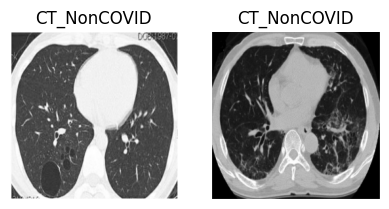

In [23]:
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

In [24]:
curModel = initiateModel(noOfClasses)

In [25]:
modelSummary(curModel)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [26]:
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)

# Train model

In [27]:
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=32)

Epoch 1/200
19/19 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.6204
Epoch 1: val_loss improved from inf to 0.71404, saving model to Covid ResNet50V2.h5
19/19 [==============================] - 57s 1s/step - loss: 0.6879 - accuracy: 0.6204 - val_loss: 0.7140 - val_accuracy: 0.5338 - lr: 1.0000e-05
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.8946
Epoch 2: val_loss improved from 0.71404 to 0.60397, saving model to Covid ResNet50V2.h5
19/19 [==============================] - 17s 873ms/step - loss: 0.3591 - accuracy: 0.8946 - val_loss: 0.6040 - val_accuracy: 0.7230 - lr: 1.0000e-05
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9666
Epoch 3: val_loss improved from 0.60397 to 0.54275, saving model to Covid ResNet50V2.h5
19/19 [==============================] - 17s 874ms/step - loss: 0.2189 - accuracy: 0.9666 - val_loss: 0.5428 - val_accuracy: 0.7770 - lr: 1.0000e-05
Epoch 4/200

# Model Metrics

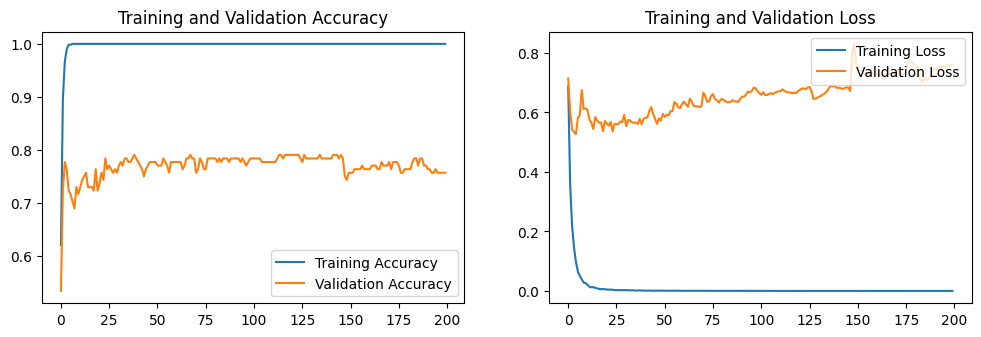

<Figure size 640x480 with 0 Axes>

In [33]:
plotOutput(curHistory, className, gEpochs)

In [29]:
evalModel(curModel)

5/5 [==============================] - 2s 316ms/step - loss: 0.7613 - accuracy: 0.7568
Accuracy on the Test Set = 75.68 %
Loss on the Test Set = 76.13 %


In [30]:
saveModel(curModel, className)

Model Saved!


True :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
5/5 [==============================] - 3s 331ms/step
Predicted :  [0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


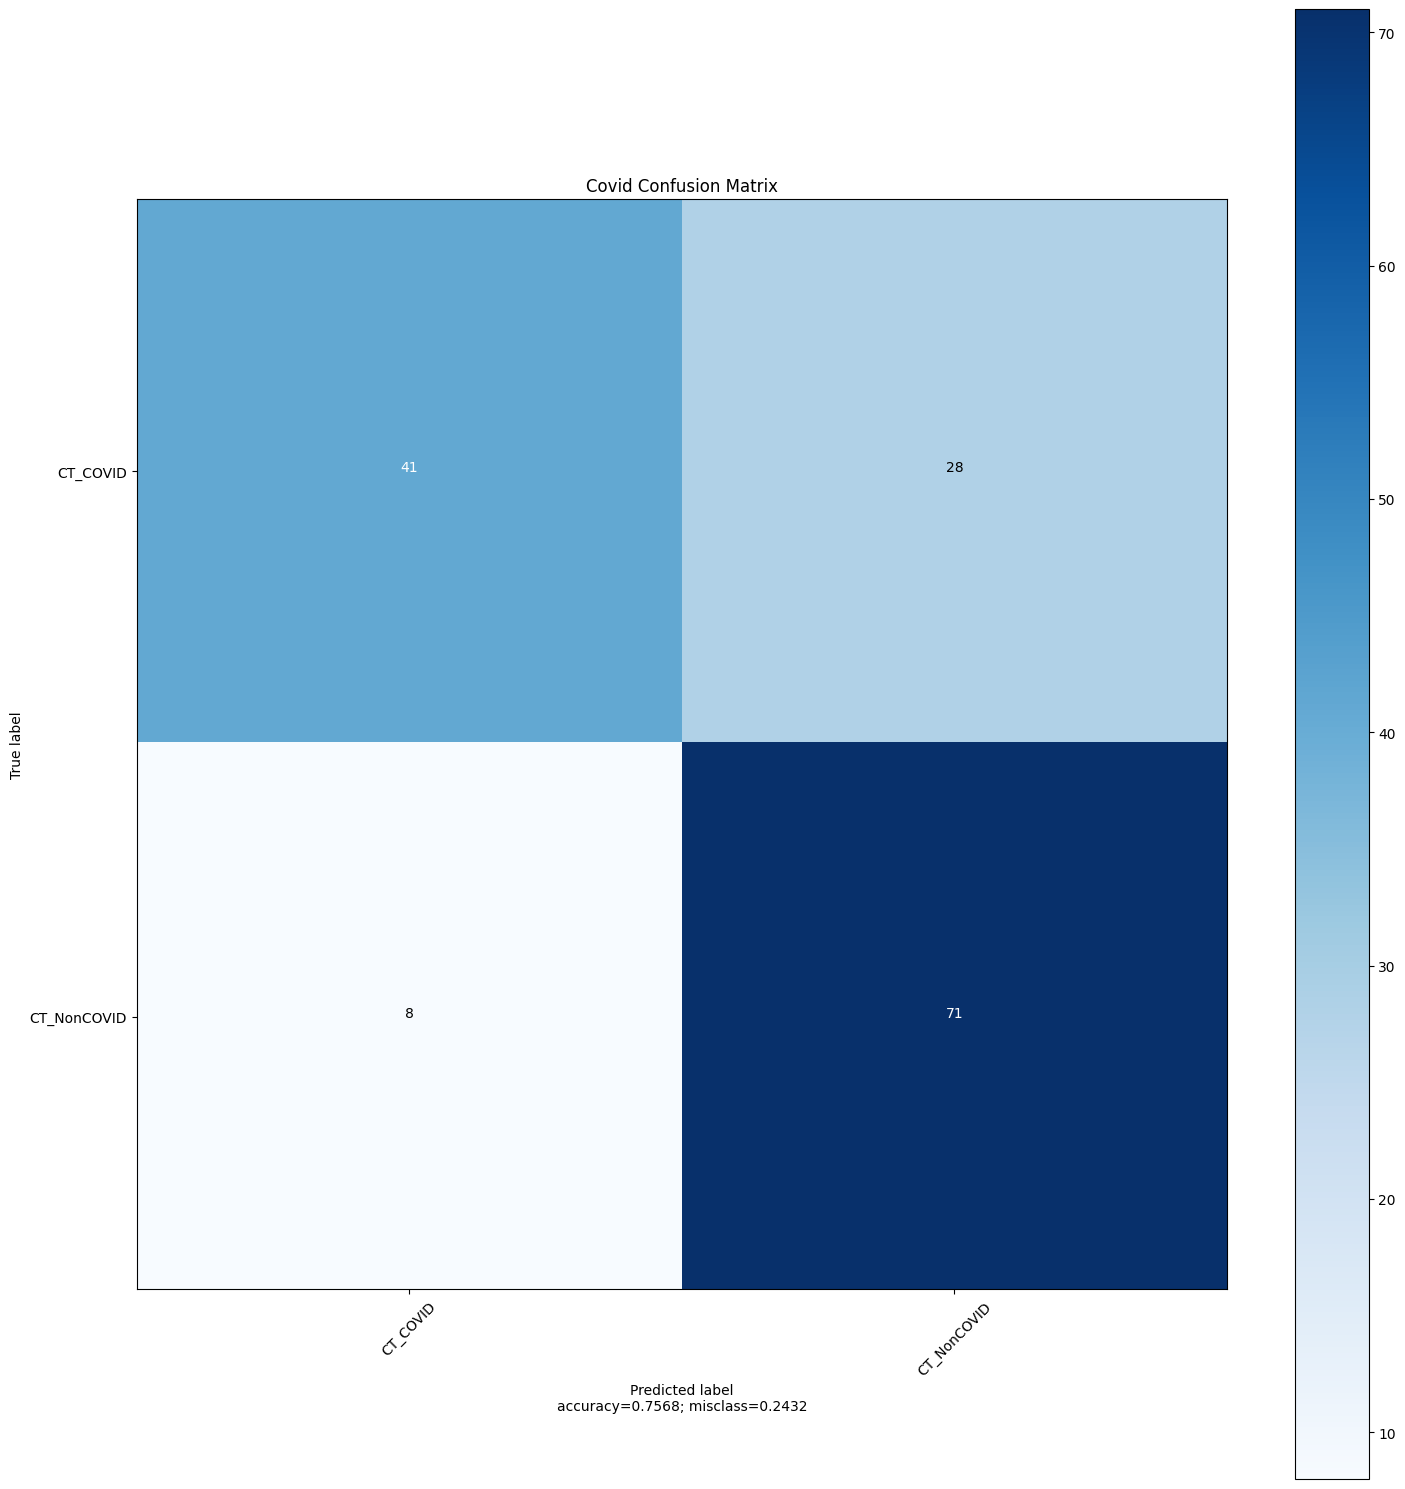

<Figure size 640x480 with 0 Axes>

In [31]:
callPlot(curModel, className, class_names)

# Test Model

1/1 [==============================] - 2s 2s/step
Covid


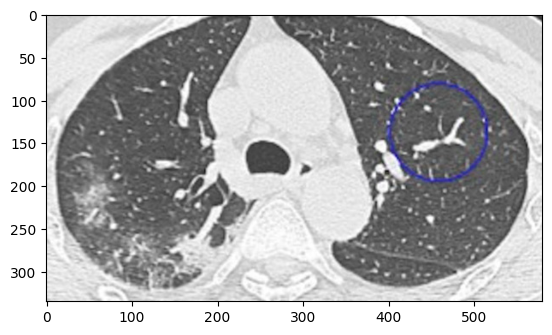

In [32]:
arr =['Covid','non_Covid']
import cv2
img = cv2.imread('/kaggle/input/covidct/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png')
import matplotlib.pyplot as plt
plt.imshow(img)
img = cv2.resize(img, (512,512))
i = np.array(img, dtype='float32')
arr_reshaped = i.reshape((-1,512,512,3))
output=curModel.predict(arr_reshaped)
result = arr[np.argmax(output)]
print(result)